**Программа CARD (Comprehensive Antibiotic Resistance Database)** — это биоинформатическая платформа, предназначенная для идентификации, анализа и интерпретации генов устойчивости к антибиотикам (ARGs) на основе последовательностей ДНК.

**CARD используется для:**

- выявления генов устойчивости в геномных, метагеномных или прочитанных данных (например, FASTA/FASTQ),

- аннотации механизмов антибиотикорезистентности,

- классификации найденных генов по типу, действию и антибиотикам, к которым они дают устойчивость.

**База данных:**

Содержит тщательно курированные сведения о генах устойчивости к антибиотикам, вариантах мутаций, механизмах действия, а также фенотипических последствиях.

Каждому гену сопоставлены:

- название,

- механизм резистентности,

- антибиотики, к которым он дает устойчивость,

- научные ссылки.

**Инструмент анализа — RGI (Resistance Gene Identifier):**

- Используется для поиска генов устойчивости в ваших данных.

- Сравнивает ваши последовательности с базой CARD с использованием алгоритмов выравнивания (например, BLAST, DIAMOND).

- Выводит список предположительно найденных ARGs с уровнем достоверности (*perfect, strict, loose*).

**Метаданные и механизмы:**

- Указывает, какой механизм действия — например, β-лактамаза, эффлюкс, изменение мишени и др.

- Помогает интерпретировать, какие антибиотики потенциально неэффективны против бактерии с данным геном.

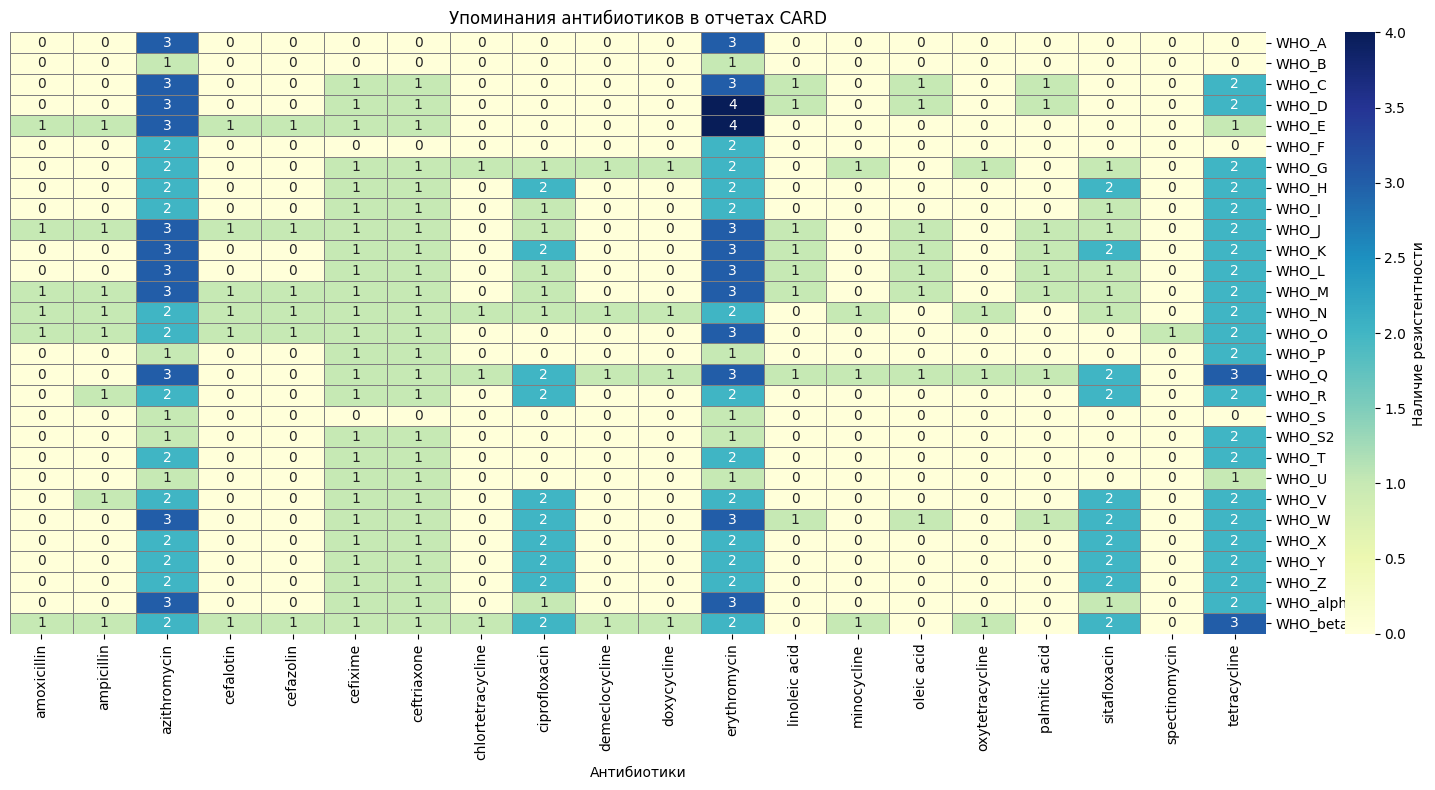

In [32]:
# @title ШАГ 1 Сколько раз упоминались антибиотики в отчетах

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import re

# Путь к папке с .txt файлами
data_folder = "/content/card"  # <-- Укажи путь к своей папке
all_files = glob(os.path.join(data_folder, "*.txt"))

df_list = []

for file in all_files:
    try:
        df = pd.read_csv(file, sep="\t", engine='python')

        # Извлекаем название штамма из имени файла (например, "WHO_A")
        filename = os.path.basename(file)
        match = re.search(r'WHO_[A-Za-z0-9]+', filename)
        if match:
            strain_name = match.group(0)
        else:
            strain_name = filename  # если не найдено — используем полное имя файла

        df['Strain'] = strain_name
        df_list.append(df[['Strain', 'Antibiotic']])
    except Exception as e:
        print(f"Ошибка при обработке {file}: {e}")

# Объединяем все данные
all_data = pd.concat(df_list, ignore_index=True)

# Обрабатываем столбец 'Antibiotic' с множественными значениями
all_data = all_data.dropna(subset=['Antibiotic'])
all_data['Antibiotic'] = all_data['Antibiotic'].str.split('; ')
all_data = all_data.explode('Antibiotic')

# Создаем сводную таблицу для тепловой карты
pivot_table = all_data.pivot_table(index='Antibiotic', columns='Strain', aggfunc='size', fill_value=0)

pivot_table = pivot_table.T  # Транспонируем: антибиотики — X, штаммы — Y

plt.figure(figsize=(16, 8))
sns.heatmap(
    pivot_table,
    cmap='YlGnBu',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Наличие резистентности'},
    yticklabels=True,
    xticklabels=True,
    annot = True
)

# Настройки оси Y — справа и горизонтально
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='left')  # Горизонтально

plt.title('Упоминания антибиотиков в отчетах CARD')
plt.ylabel('Штаммы')
plt.xlabel('Антибиотики')
plt.tight_layout()
plt.show()

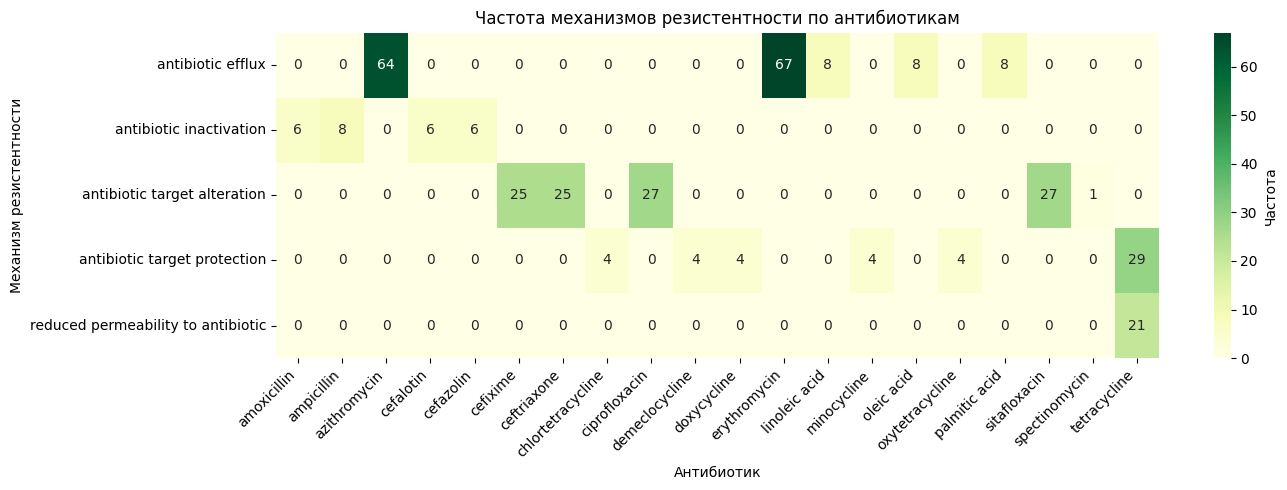

In [2]:
# @title ШАГ 2 Частота встречаемости механизмов устойчивости

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Путь к папке с .txt файлами
data_dir = "/content/card"

# Словарь для подсчета пар (антибиотик, механизм)
pair_counts = defaultdict(int)

# Обработка всех .txt файлов
for filename in os.listdir(data_dir):
    if filename.endswith(".txt"):
        filepath = os.path.join(data_dir, filename)
        try:
            df = pd.read_csv(filepath, sep="\t", dtype=str)

            for _, row in df.iterrows():
                antibiotics = row.get("Antibiotic", "")
                mechanism = row.get("Resistance Mechanism", "")

                if pd.isna(antibiotics) or pd.isna(mechanism):
                    continue

                # Обработка множественных антибиотиков
                for ab in antibiotics.split(";"):
                    ab = ab.strip()
                    if ab:
                        pair_counts[(ab, mechanism.strip())] += 1

        except Exception as e:
            print(f"Ошибка при обработке файла {filename}: {e}")

# Преобразование в DataFrame
pair_df = pd.DataFrame.from_dict(pair_counts, orient="index", columns=["Count"])
pair_df.index = pd.MultiIndex.from_tuples(pair_df.index, names=["Antibiotic", "Mechanism"])
pair_df = pair_df.reset_index()

# Поворот таблицы для heatmap
pivot = pair_df.pivot(index="Mechanism", columns="Antibiotic", values="Count").fillna(0)

# Построение графика
plt.figure(figsize=(14, 5))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGn", cbar_kws={"label": "Частота"})
plt.title("Частота механизмов резистентности по антибиотикам")
plt.xlabel("Антибиотик")
plt.ylabel("Механизм резистентности")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


| Механизм                               | Объяснение                                                                                                                                                                                                                      |
|----------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **antibiotic efflux**                  | 🔁 **Выброс антибиотика** — бактерия использует специальные белки (т.н. насосы), чтобы активно выталкивать антибиотик наружу до того, как он успеет подействовать. Это универсальный и часто встречающийся механизм.         |
| **antibiotic target alteration**       | 🎯 **Изменение мишени антибиотика** — бактерия модифицирует структуру мишени (например, рибосомы или ферменты), к которой должен был присоединиться антибиотик. В результате антибиотик теряет эффективность.                |
| **antibiotic target protection**       | 🛡️ **Защита мишени антибиотика** — бактерия производит белки, которые связываются с мишенью антибиотика и мешают самому антибиотику эффективно взаимодействовать с ней.                                                       |
| **reduced permeability to antibiotic** | 🚪 **Снижение проницаемости** — бактерия изменяет структуру своей клеточной стенки или мембранных пор, что затрудняет проникновение антибиотика внутрь.                                                                        |
| **antibiotic inactivation**            | 💥 **Инактивация антибиотика** — бактерия синтезирует ферменты, которые разрушают или модифицируют антибиотик, делая его неэффективным. Примеры: β-лактамазы, ацетилтрансферазы, фосфотрансферазы.                            |


In [3]:
# @title ШАГ 3 Ищу АРГ

import pandas as pd
import glob

# Путь ко всем txt-файлам в папке
files = glob.glob("/content/card/*.txt")

# Список для хранения всех датафреймов
all_data = []

for file in files:
    df = pd.read_csv(file, sep='\t')  # если разделитель табуляция
    df['Source_File'] = file  # чтобы знать из какого файла данные
    all_data.append(df)

# Объединение всех датафреймов в один
combined_df = pd.concat(all_data, ignore_index=True)

# Сохраняем как Excel или CSV
combined_df.to_csv("combined_data.csv", index=False)
combined_df.to_excel("combined_data.xlsx", index=False)


In [4]:
# @title ШАГ 4 Уникальные гены

import glob

all_files = glob.glob("/content/card/*.txt")
all_genes = set()

for file in all_files:
    try:
        df = pd.read_csv(file, sep="\t", engine='python')
        genes = df["Best_Hit_ARO"].unique()
        all_genes.update(genes)
    except Exception as e:
        print(f"Ошибка в файле {file}: {e}")

# Вывод всех уникальных генов
for gene in sorted(all_genes):
    print(gene)


Neisseria gonorrhoeae 16S rRNA mutation conferring resistance to spectinomycin
Neisseria gonorrhoeae PBP1 conferring resistance to beta-lactam antibiotics
Neisseria gonorrhoeae PBP2 conferring resistance to beta-lactam antibiotics
Neisseria gonorrhoeae gyrA with mutations conferring resistance to fluoroquinolones
Neisseria gonorrhoeae mtrC with mutation conferring resistance to azithromycin
Neisseria gonorrhoeae mtrR with mutation conferring resistance
Neisseria gonorrhoeae parC conferring resistance to fluoroquinolones
Neisseria gonorrhoeae porin PIB (por)
TEM-1
TEM-135
macA
macB
mtrA
mtrR
rpsJ
tet(M)


In [22]:
# @title ШАГ 5 Проверяю на иные названия тех же генов, получаю количество каждого гена

import pandas as pd
import os
import glob
import re

# 📁 Путь к папке с файлами CARD
folder_path = "card"

# 🔁 Собираем все файлы
all_files = glob.glob(os.path.join(folder_path, "*.tsv")) + glob.glob(os.path.join(folder_path, "*.txt"))

# 🧬 Маппинг генов
gene_mapping = {
    # Существующие маппинги из вашего кода
    "pbp2": "penA",
    "pbp1": "ponA",
    "gyra": "gyrA",
    "parc": "parC",
    "mtrc": "mtrC",
    "mtrr": "mtrR",
    "mtra": "mtrA",
    "por": "porB",
    "porin pib": "porB", # "porin PIB" также должен быть учтен
    "rpsj": "rpsJ",
    "tem-1": "TEM-1",
    "tem-135": "TEM-135",
    "tet(m)": "tet(M)",
    "macb": "macB",
    "maca": "macA",
    "16s rrna": "16S rRNA",

    # Добавленные синонимы и варианты написания на основе ваших уникальных значений
    # и общих знаний

    # Neisseria gonorrhoeae 16S rRNA mutation conferring resistance to spectinomycin
    "neisseria gonorrhoeae 16s rrna": "16S rRNA", # Более общее совпадение
    "16s ribosomal rna": "16S rRNA",
    "16s_rrna": "16S rRNA",

    # Neisseria gonorrhoeae PBP1 conferring resistance to beta-lactam antibiotics
    "neisseria gonorrhoeae pbp1": "ponA",
    "neisseria gonorrhoeae penicillin-binding protein 1": "ponA",
    "penicillin-binding protein 1": "ponA",
    "pona": "ponA", # Убедимся, что 'pona' тоже маппится

    # Neisseria gonorrhoeae PBP2 conferring resistance to beta-lactam antibiotics
    "neisseria gonorrhoeae pbp2": "penA",
    "neisseria gonorrhoeae penicillin-binding protein 2": "penA",
    "penicillin-binding protein 2": "penA",
    "pena": "penA", # Убедимся, что 'pena' тоже маппится

    # Neisseria gonorrhoeae gyrA with mutations conferring resistance to fluoroquinolones
    "neisseria gonorrhoeae gyra": "gyrA",
    "gyrase subunit a": "gyrA",
    "dna gyrase subunit a": "gyrA",

    # Neisseria gonorrhoeae mtrC with mutation conferring resistance to azithromycin
    "neisseria gonorrhoeae mtrc": "mtrC",
    "mtrc efflux pump": "mtrC",

    # Neisseria gonorrhoeae mtrR with mutation conferring resistance
    "neisseria gonorrhoeae mtrr": "mtrR",
    "mtrr transcriptional regulator": "mtrR",

    # Neisseria gonorrhoeae parC conferring resistance to fluoroquinolones
    "neisseria gonorrhoeae parc": "parC",
    "topoisomerase iv subunit a": "parC", # Альтернативное название
    "parc topoisomerase": "parC",

    # Neisseria gonorrhoeae porin PIB (por)
    "neisseria gonorrhoeae porin pib": "porB",
    "neisseria gonorrhoeae por": "porB",
    "porin b": "porB",
    "porb": "porB", # Убедимся, что 'porb' тоже маппится

    # TEM-1, TEM-135 - уже хорошо маппятся, но добавим вариации
    "beta-lactamase tem-1": "TEM-1",
    "tem 1": "TEM-1",
    "beta-lactamase tem-135": "TEM-135",
    "tem 135": "TEM-135",

    # macA, macB - уже хорошо маппятся, но добавим вариации
    "maca efflux protein": "macA",
    "macrolide efflux protein a": "macA",
    "macb efflux protein": "macB",
    "macrolide efflux protein b": "macB",

    # mtrA, mtrR - уже хорошо маппятся, но добавим вариации
    "mtra efflux regulator": "mtrA",
    "mtrr efflux regulator": "mtrR",

    # rpsJ - уже хорошо маппится, но добавим вариации
    "ribosomal protein sj": "rpsJ",
    "30s ribosomal protein sj": "rpsJ",

    # tet(M) - уже хорошо маппится, но добавим вариации
    "tetm": "tet(M)",
    "tetracycline resistance protein tetm": "tet(M)",
    "tetracycline resistance gene tet(m)": "tet(M)",
}

# 🧼 Функция извлечения гена
# 🧼 Функция извлечения гена (улучшенная версия)
def extract_gene_name(entry):
    original_entry = entry # Сохраняем оригинальную запись для отладки
    entry_lower = entry.lower()

    # 1. Сначала проверяем на специфичные и длинные совпадения из gene_mapping
    # Отсортируем ключи по убыванию длины, чтобы более специфичные совпадения (например, "neisseria gonorrhoeae 16s rrna")
    # имели приоритет над более короткими ("16s rrna").
    for key in sorted(gene_mapping.keys(), key=len, reverse=True):
        if key in entry_lower:
            return gene_mapping[key]

    # 2. Если прямого совпадения нет, попробуем извлечь известные части генов,
    # даже если они находятся в более длинном описании без точного совпадения ключа.
    # Это может быть полезно для новых описаний, которые не были добавлены в маппинг.
    # Пример: 'PBP2' из "Some other PBP2 variant"

    # Список известных основных генов для Neisseria gonorrhoeae
    # Это позволяет нам извлечь "чистое" название гена, даже если нет полного соответствия в словаре.
    known_ng_genes = [
        "penA", "ponA", "gyrA", "parC", "mtrC", "mtrR", "mtrA", "porB",
        "16S rRNA", "TEM-1", "TEM-135", "macA", "macB", "rpsJ", "tet(M)"
    ]

    for gene_core in known_ng_genes:
        # Ищем точное вхождение основного имени гена (без учета регистра)
        if gene_core.lower() in entry_lower:
            return gene_core # Возвращаем стандартизированное имя гена

    # 3. Fallback: Если ничего не найдено, попробовать извлечь ключевые слова
    # (ваш предыдущий regex был слишком строгим).
    # Этот regex пытается найти последовательность букв, цифр, дефисов, скобок.
    # Можно сделать его более общим.
    match = re.search(r"\b([a-z0-9\-_\(\)]+)\b", entry_lower)
    if match:
        # Если найдено короткое "слово", попытаемся его использовать, но это рискованно.
        # Лучше всего, если все будет замаппировано.
        # return match.group(1).strip()
        # Вместо возврата первого попавшегося слова, лучше вернуть обрезанную версию
        # оригинальной строки, чтобы вручную просмотреть.
        pass # Переходим к следующему шагу

    # 4. Последний вариант: если ничего не подошло, вернуть укороченную версию оригинальной строки
    # или пометить как "НЕИЗВЕСТНЫЙ_ГЕН" для последующего ручного анализа.
    # Не обрезайте до 30 символов бездумно. Лучше сохранить больше информации для отладки.
    return f"НЕИЗВЕСТНЫЙ_ГЕН: {original_entry[:50].strip()}" # Обрезаем, но с префиксом для идентификации

# 📊 Сбор всех результатов
all_genes = []

for file in all_files:
    try:
        df = pd.read_csv(file, sep="\t", engine="python")

        if "Best_Hit_ARO" not in df.columns:
            print(f"Пропущен файл (нет колонки Best_Hit_ARO): {file}")
            continue

        df["Cleaned_Gene"] = df["Best_Hit_ARO"].apply(extract_gene_name)

        # Добавим колонку с названием штамма
        filename = os.path.basename(file)
        strain = re.search(r"WHO_[A-Za-z0-9]+", filename)
        strain_name = strain.group(0) if strain else filename
        df["Strain"] = strain_name

        all_genes.append(df[["Strain", "Cleaned_Gene"]])

    except Exception as e:
        print(f"Ошибка в файле {file}: {e}")

# 🧩 Объединяем все
all_data = pd.concat(all_genes)

# 👁 Показываем сводку всех уникальных генов
gene_summary = all_data["Cleaned_Gene"].value_counts().reset_index()
gene_summary.columns = ["Gene", "Total_Count"]
print(gene_summary)


        Gene  Total_Count
0       mtrA           29
1       penA           25
2       rpsJ           25
3       mtrC           24
4       ponA           22
5       porB           21
6       gyrA           17
7       mtrR           11
8       parC           10
9      TEM-1            6
10    tet(M)            4
11   TEM-135            2
12      macB            2
13  16S rRNA            1
14      macA            1


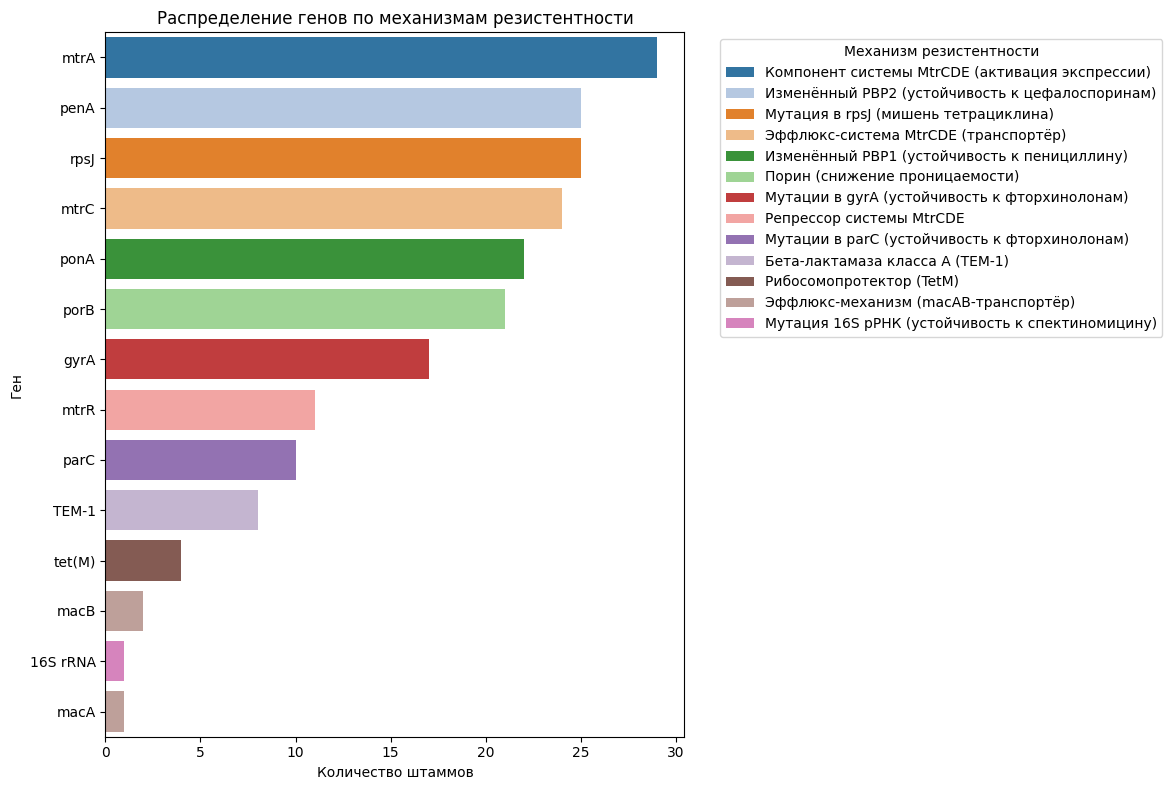

In [21]:
# @title ШАГ 6 Визуализация

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Таблица: гены, механизмы и количество штаммов
data = {
    "Gene": [
        "mtrA", "penA", "rpsJ", "mtrC", "ponA", "porB",
        "gyrA", "mtrR", "parC", "TEM-1", "tet(M)",
        "macB", "16S rRNA", "macA"
    ],
    "Mechanism": [
        "Компонент системы MtrCDE (активация экспрессии)",
        "Изменённый PBP2 (устойчивость к цефалоспоринам)",
        "Мутация в rpsJ (мишень тетрациклина)",
        "Эффлюкс-система MtrCDE (транспортёр)",
        "Изменённый PBP1 (устойчивость к пенициллину)",
        "Порин (снижение проницаемости)",
        "Мутации в gyrA (устойчивость к фторхинолонам)",
        "Репрессор системы MtrCDE",
        "Мутации в parC (устойчивость к фторхинолонам)",
        "Бета-лактамаза класса A (TEM-1)",
        "Рибосомопротектор (TetM)",
        "Эффлюкс-механизм (macAB-транспортёр)",
        "Мутация 16S рРНК (устойчивость к спектиномицину)",
        "Эффлюкс-механизм (macAB-транспортёр)"
    ],
    "Strain_Count": [29, 25, 25, 24, 22, 21, 17, 11, 10, 8, 4, 2, 1, 1]
}

df = pd.DataFrame(data)

# Построение графика
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x="Strain_Count", y="Gene", hue="Mechanism", dodge=False, palette="tab20")

plt.xlabel("Количество штаммов")
plt.ylabel("Ген")
plt.title("Распределение генов по механизмам резистентности")
plt.legend(title="Механизм резистентности", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Подробнее:**

| Ген                    | Что это                       | Механизм резистентности                                                                  |
| ---------------------- | ----------------------------- | ---------------------------------------------------------------------------------------- |
| **penA**               | β-лактамаза (PBP2)            | Мутации в **penA** (PBP2) снижают аффинность β-лактамов — устойчивость к цефалоспоринам. |
| **ponA**               | PBP1                          | Мутации снижают чувствительность к пенициллину.                                          |
| **mtrA / mtrC / mtrR** | Компоненты **MtrCDE**-системы | Эффлюкс антибиотиков: выбрасывают макролиды, β-лактамы, фторхинолоны.                    |
| **porB**               | Порин PIB                     | Изменения → снижают проницаемость внешней мембраны.                                      |
| **gyrA / parC**        | ТОП-изомеразы                 | Мутации → устойчивость к фторхинолонам.                                                  |
| **rpsJ**               | Рибосомный белок              | Мутации → устойчивость к тетрациклину.                                                   |
| **TEM-1**              | β-лактамаза                   | Разрушает пенициллины.                                                                   |
| **tet(M)**             | Рибосомопротектор             | Защищает рибосому от действия тетрациклина.                                              |
| **macA / macB**        | Эффлюкс-система               | Выкачивает макролиды (например, азитромицин).                                            |
| **16S rRNA**           | Рибосомная РНК                | Мутации → устойчивость к спектиномицину.                                                 |


/tmp/ipython-input-29-496204940.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  gene_presence_binary = gene_presence.applymap(lambda x: 1 if x > 0 else 0)


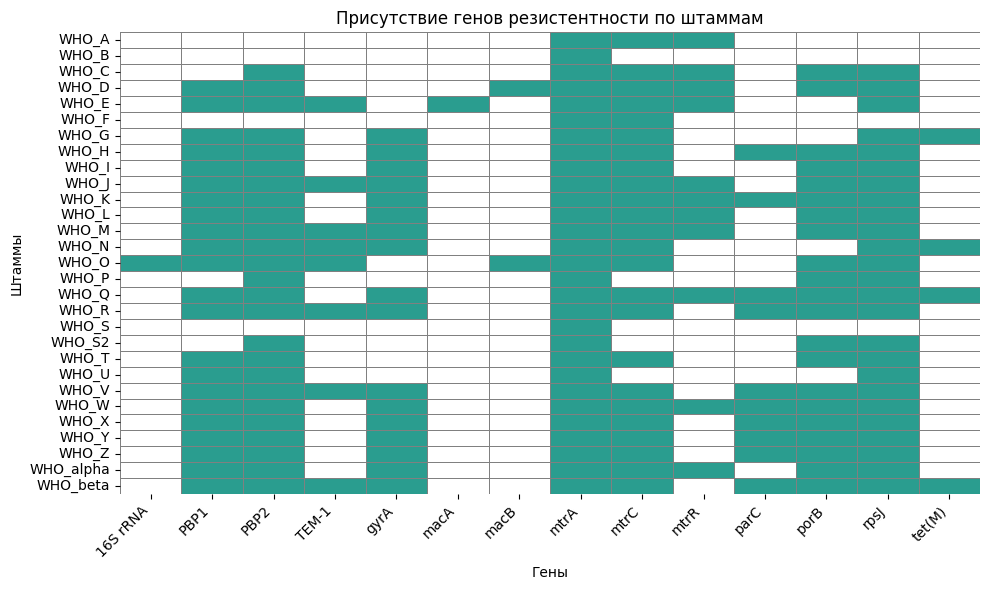

/tmp/ipython-input-29-496204940.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gene_counts_per_strain_sorted.values, y=gene_counts_per_strain_sorted.index, palette="viridis")


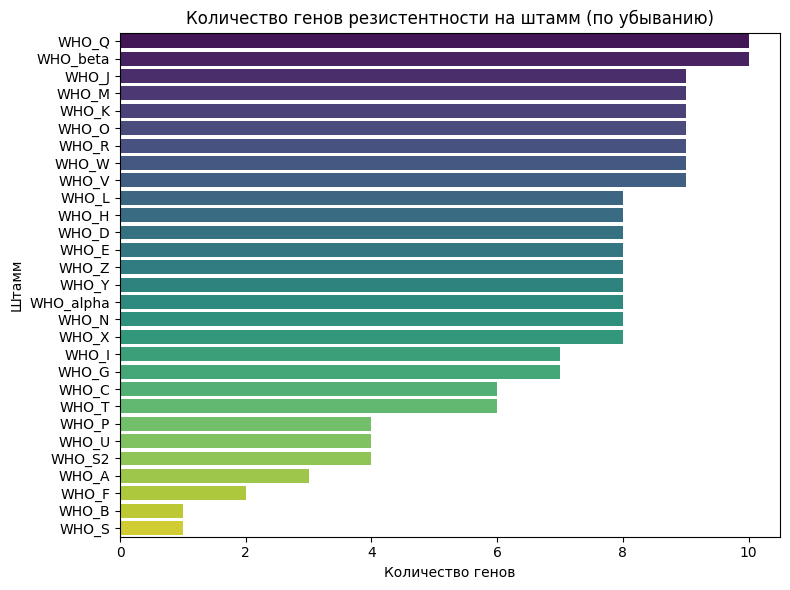

In [29]:
# @title ШАГ 7 Какой ген в каком штамме и их количество

import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

# 🔍 1. Задаём гены, которые нас интересуют
target_genes = {
    "neisseria gonorrhoeae 16s rrna": "16S rRNA",
    "pbp1": "PBP1",
    "pbp2": "PBP2",
    "gyra": "gyrA",
    "mtrc": "mtrC",
    "mtrr": "mtrR",
    "parc": "parC",
    "por": "porB",      # уточнённое название
    "tem-1": "TEM-1",
    "tem-135": "TEM-135",
    "maca": "macA",
    "macb": "macB",
    "mtra": "mtrA",
    "rpsj": "rpsJ",
    "tet(m)": "tet(M)",
    "pena": "penA",      # добавим penA (PBP2)
    "pona": "ponA"       # добавим ponA (PBP1)
}

# 🔄 2. Функция для упрощения названия гена
def simplify_gene(name):
    name_lower = name.lower()
    for key, simple in target_genes.items():
        if key in name_lower:
            return simple
    return None

# 📂 3. Чтение всех файлов из папки
folder_path = "card"    # ← путь к твоей папке
all_files = glob(os.path.join(folder_path, "*.txt"))

df_list = []

for file in all_files:
    try:
        df = pd.read_csv(file, sep="\t", engine='python')
        filename = os.path.basename(file)
        match = re.search(r'WHO_[A-Za-z0-9]+', filename)
        strain = match.group(0) if match else filename
        df["Strain"] = strain
        df["gene_cleaned"] = df["Best_Hit_ARO"].apply(simplify_gene)
        df_filtered = df.dropna(subset=["gene_cleaned"])
        df_list.append(df_filtered[["Strain", "gene_cleaned"]])
    except Exception as e:
        print(f"Ошибка при обработке {file}: {e}")

# 📊 4. Объединяем и создаём сводную таблицу
all_data = pd.concat(df_list, ignore_index=True)

# Группируем по штамму и гену, затем unstack, чтобы получить столбцы для каждого гена
gene_presence = all_data.groupby(["Strain", "gene_cleaned"]).size().unstack(fill_value=0)

# 🔁 Преобразуем в бинарную (0/1) таблицу - нас интересует только наличие гена
gene_presence_binary = gene_presence.applymap(lambda x: 1 if x > 0 else 0)

# 🖼️ 5. Визуализация heatmap
plt.figure(figsize=(10,6)) # Увеличиваем размер для лучшей читаемости
sns.heatmap(gene_presence_binary, cmap=["#ffffff", "#2a9d8f"], cbar=False, linewidths=0.5, linecolor='gray')

plt.title("Присутствие генов резистентности по штаммам")
plt.xlabel("Гены")
plt.ylabel("Штаммы")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Построение гистограммы количества генов на штамм
# 📈 6. Строим гистограмму количества генов для каждого штамма
# Подсчитываем сумму бинарных значений для каждого штамма (количество уникальных генов)
gene_counts_per_strain = gene_presence_binary.sum(axis=1)

# Сортируем штаммы по убыванию количества генов
gene_counts_per_strain_sorted = gene_counts_per_strain.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=gene_counts_per_strain_sorted.values, y=gene_counts_per_strain_sorted.index, palette="viridis")

plt.title("Количество генов резистентности на штамм (по убыванию)")
plt.xlabel("Количество генов")
plt.ylabel("Штамм")
plt.xticks(rotation=0) # Метки по X теперь не нужно поворачивать
plt.tight_layout()
plt.show()

In [8]:
# @title ШАГ 8 Классы антибиотиков

import pandas as pd
import os
from glob import glob

# Путь к папке с файлами
folder_path = "card"  # Измени путь при необходимости
all_files = glob(os.path.join(folder_path, "*.txt"))

antibiotic_columns = ["Drug Class", "Drug_Class", "Drug_Class_Name", "Antibiotic", "Resistance Mechanism", "AMR Gene Family"]

unique_antibiotics = set()

for file in all_files:
    try:
        df = pd.read_csv(file, sep="\t", engine='python')
        # Пытаемся найти нужную колонку
        for col in antibiotic_columns:
            if col in df.columns:
                unique_antibiotics.update(df[col].dropna().unique())
                break
    except Exception as e:
        print(f"Ошибка при обработке {file}: {e}")

# Выводим все уникальные классы антибиотиков
print("Уникальные классы/антибиотики, найденные в данных:")
for ab in sorted(unique_antibiotics):
    print(ab)


Уникальные классы/антибиотики, найденные в данных:
aminoglycoside antibiotic
cephalosporin; penicillin beta-lactam
fluoroquinolone antibiotic
macrolide antibiotic
macrolide antibiotic; antibacterial free fatty acids
monobactam; carbapenem; cephalosporin; penicillin beta-lactam; tetracycline antibiotic
monobactam; cephalosporin; penicillin beta-lactam
tetracycline antibiotic


In [9]:
# @title ШАГ 9 Уникальные механизмы резистентности

import pandas as pd
import os
from glob import glob

folder_path = "card"  # Путь к папке с файлами
all_files = glob(os.path.join(folder_path, "*.txt"))

amr_gene_family_values = set()

for file in all_files:
    try:
        df = pd.read_csv(file, sep="\t", engine='python')
        if "AMR Gene Family" in df.columns:
            amr_gene_family_values.update(df["AMR Gene Family"].dropna().unique())
    except Exception as e:
        print(f"Ошибка при обработке {file}: {e}")

print("Уникальные значения в колонке 'AMR Gene Family':")
for val in sorted(amr_gene_family_values):
    print(val)


Уникальные значения в колонке 'AMR Gene Family':
16s rRNA with mutation conferring resistance to aminoglycoside antibiotics
ATP-binding cassette (ABC) antibiotic efflux pump
General Bacterial Porin with reduced permeability to beta-lactams
Penicillin-binding protein mutations conferring resistance to beta-lactam antibiotics
TEM beta-lactamase
fluoroquinolone resistant gyrA
fluoroquinolone resistant parC
major facilitator superfamily (MFS) antibiotic efflux pump; resistance-nodulation-cell division (RND) antibiotic efflux pump
resistance-nodulation-cell division (RND) antibiotic efflux pump
tetracycline-resistant ribosomal protection protein


In [10]:
# @title ШАГ 10 Создание файла с белками

import pandas as pd
import os
from glob import glob

folder_path = "card"  # Путь к папке с файлами
all_files = glob(os.path.join(folder_path, "*.txt"))

# Список для хранения данных из всех файлов
protein_data = []

for file in all_files:
    try:
        df = pd.read_csv(file, sep="\t", engine='python')
        # Проверяем, есть ли нужные колонки
        if "Predicted_Protein" in df.columns and "CARD_Protein_Sequence" in df.columns:
            # Извлекаем нужные колонки и добавляем в список
            protein_data.append(df[["Predicted_Protein", "CARD_Protein_Sequence"]].dropna())
    except Exception as e:
        print(f"Ошибка при обработке {file}: {e}")

# Объединяем все данные в один DataFrame
if protein_data:
    all_proteins_df = pd.concat(protein_data, ignore_index=True)
    # Сохраняем в CSV
    all_proteins_df.to_csv("extracted_proteins.csv", index=False)
    print("Данные успешно сохранены в 'extracted_proteins.csv'")
else:
    print("Не найдено данных в указанных колонках.")


Данные успешно сохранены в 'extracted_proteins.csv'


In [11]:
# @title ШАГ 11 Создание файла белков со штаммами

import pandas as pd
import os
import re
from glob import glob

folder_path = "card"  # Путь к папке с файлами
all_files = glob(os.path.join(folder_path, "*.txt"))

df_list = []

for file in all_files:
    try:
        df = pd.read_csv(file, sep="\t", engine='python')

        # Извлекаем название штамма из имени файла (например, "WHO_A")
        filename = os.path.basename(file)
        match = re.search(r'WHO_[A-Za-z0-9]+', filename)
        if match:
            strain_name = match.group(0)
        else:
            strain_name = filename  # если не найдено — используем полное имя файла

        # Проверяем наличие нужных колонок
        if "Predicted_Protein" in df.columns and "CARD_Protein_Sequence" in df.columns:
            # Добавляем колонку со штаммом
            df['Strain'] = strain_name
            # Выбираем нужные колонки
            df_list.append(df[['Strain', 'Predicted_Protein', 'CARD_Protein_Sequence']].dropna())
    except Exception as e:
        print(f"Ошибка при обработке {file}: {e}")

if df_list:
    all_proteins_df = pd.concat(df_list, ignore_index=True)
    all_proteins_df.to_csv("proteins_with_strain.csv", index=False)
    print("Данные успешно сохранены в 'proteins_with_strain.csv'")
else:
    print("Данные не найдены в указанных колонках.")


Данные успешно сохранены в 'proteins_with_strain.csv'


In [12]:
# @title ШАГ 12 Создание файла предсказанных белков со штаммами

import pandas as pd
import os
import re
from glob import glob

folder_path = "card"  # Путь к папке с файлами
all_files = glob(os.path.join(folder_path, "*.txt"))

df_list = []

for file in all_files:
    try:
        df = pd.read_csv(file, sep="\t", engine='python')

        # Извлекаем название штамма из имени файла (например, "WHO_A")
        filename = os.path.basename(file)
        match = re.search(r'WHO_[A-Za-z0-9]+', filename)
        if match:
            strain_name = match.group(0)
        else:
            strain_name = filename

        # Проверяем наличие нужных колонок
        required_cols = ["ORF_ID", "ARO", "Predicted_DNA"]
        if all(col in df.columns for col in required_cols):
            df['Strain'] = strain_name
            df_list.append(df[required_cols + ['Strain']].dropna(subset=["Predicted_DNA"]))
    except Exception as e:
        print(f"Ошибка при обработке {file}: {e}")

if df_list:
    all_genes_df = pd.concat(df_list, ignore_index=True)
    all_genes_df.to_csv("predicted_genes_with_strain.csv", index=False)
    print("Данные успешно сохранены в 'predicted_genes_with_strain.csv'")
else:
    print("Не найдено данных в указанных колонках.")


Данные успешно сохранены в 'predicted_genes_with_strain.csv'


| Основной класс                       | Подкласс/группа                                      | Примеры из списка                                                                                                                                           | Механизм действия                                                                      | Применение при гонорее / комментарий                                                                |
| ------------------------------------ | ---------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------- |
| **Бета-лактамы**                     | Пенициллины, Цефалоспорины, Монобактамы, Карбапенемы | cephalosporin; penicillin beta-lactam<br>monobactam; cephalosporin; penicillin beta-lactam<br>monobactam; carbapenem; cephalosporin; penicillin beta-lactam | Нарушение синтеза клеточной стенки (ингибирование пенициллин-связывающих белков, PBPs) | Широко применялись против *N. gonorrhoeae*. Устойчивость через **PBP2 (penA)**, **TEM-1**, **ponA** |
| **Фторхинолоны**                     | —                                                    | fluoroquinolone antibiotic                                                                                                                                  | Ингибирование ДНК-гиразы и топоизомеразы IV                                            | Использовались, но часто встречается устойчивость через **gyrA**, **parC**                          |
| **Макролиды**                        | —                                                    | macrolide antibiotic<br>macrolide antibiotic; antibacterial free fatty acids                                                                                | Блокировка трансляции белка (50S субъединица рибосомы)                                 | Например, **азитромицин**. Устойчивость через **mtrCDE**, **macA/B**, **mtrR**                      |
| **Тетрациклины**                     | —                                                    | tetracycline antibiotic<br>monobactam; carbapenem; cephalosporin; penicillin beta-lactam; tetracycline antibiotic                                           | Блокировка трансляции белка (30S субъединица рибосомы)                                 | Ранее использовались. Устойчивость через **rpsJ**, **tet(M)**                                       |
| **Аминогликозиды**                   | —                                                    | aminoglycoside antibiotic                                                                                                                                   | Нарушение синтеза белка (30S рибосома, нарушение инициации)                            | Используются экспериментально. Механизмы устойчивости разнообразны.                                 |
| **Антибактериальные жирные кислоты** | —                                                    | macrolide antibiotic; antibacterial free fatty acids                                                                                                        | Различные механизмы: нарушение мембраны, угнетение роста                               | Редкое направление, возможна перекрёстная устойчивость.                                             |


/tmp/ipython-input-13-2120274802.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_summary, x="Strain_Count", y="Class", palette="Set3")


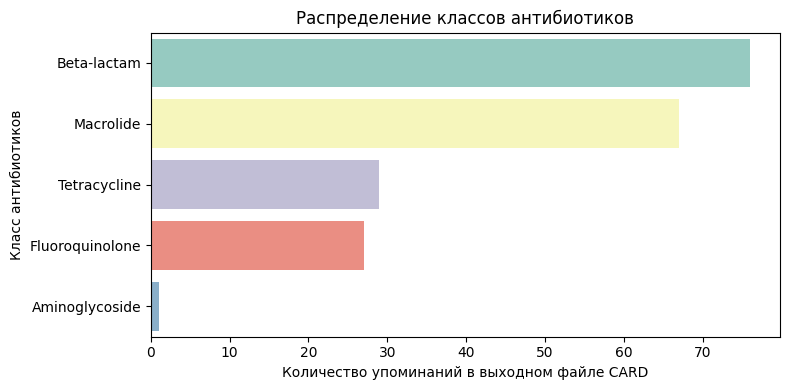

In [13]:
# @title ШАГ 13 Визуализация по классам антибиотиков

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Данные: гены, классы и количество штаммов
data = {
    "Gene": ["mtrA", "mtrC", "mtrR", "macA", "macB", "TEM-1", "TEM-135", "penA", "ponA", "porB",
             "gyrA", "parC", "rpsJ", "tet(M)", "16S rRNA"],
    "Class": [
        "Macrolide", "Macrolide", "Macrolide", "Macrolide", "Macrolide",
        "Beta-lactam", "Beta-lactam", "Beta-lactam", "Beta-lactam", "Beta-lactam",
        "Fluoroquinolone", "Fluoroquinolone",
        "Tetracycline", "Tetracycline",
        "Aminoglycoside"
    ],
    "Strain_Count": [29, 24, 11, 1, 2, 8, 0, 25, 22, 21, 17, 10, 25, 4, 1]
}

df = pd.DataFrame(data)

# Группировка по классу
class_summary = df.groupby("Class")["Strain_Count"].sum().reset_index()

# Сортировка
class_summary = class_summary.sort_values("Strain_Count", ascending=False)

# Визуализация
plt.figure(figsize=(8, 4))
sns.barplot(data=class_summary, x="Strain_Count", y="Class", palette="Set3")

plt.title("Распределение классов антибиотиков")
plt.xlabel("Количество упоминаний в выходном файле CARD")
plt.ylabel("Класс антибиотиков")
plt.tight_layout()
plt.show()

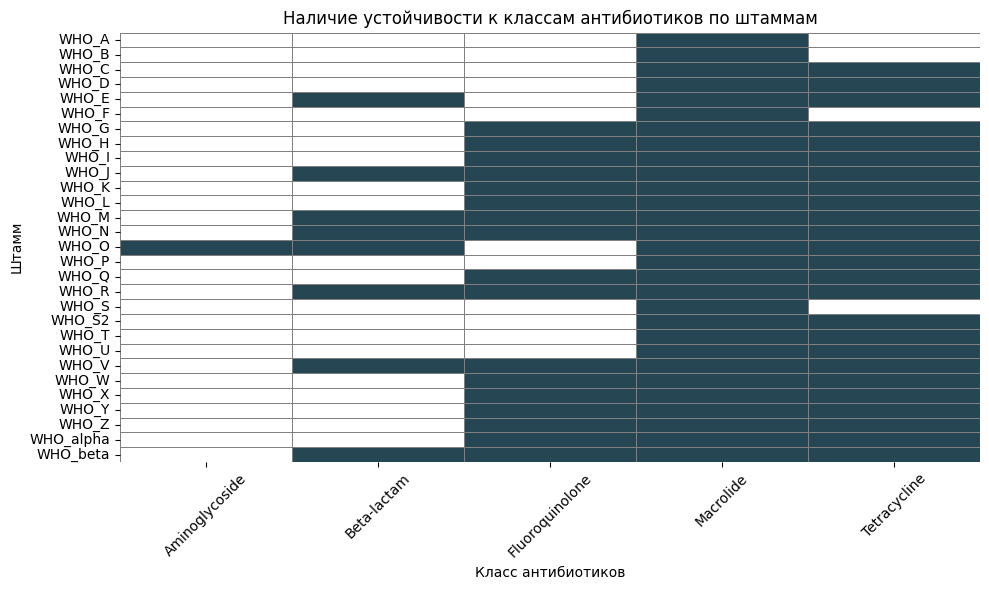

In [14]:
# @title ШАГ 14 Разбиваем штаммы по классам антибиотиков

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from glob import glob
import re

# 🔍 Соответствие генов и классов антибиотиков
gene_class_map = {
    "mtrA": "Macrolide", "mtrC": "Macrolide", "mtrR": "Macrolide",
    "macA": "Macrolide", "macB": "Macrolide",
    "TEM-1": "Beta-lactam", "TEM-135": "Beta-lactam", "penA": "Beta-lactam",
    "ponA": "Beta-lactam", "porB": "Beta-lactam",
    "gyrA": "Fluoroquinolone", "parC": "Fluoroquinolone",
    "rpsJ": "Tetracycline", "tet(M)": "Tetracycline",
    "16S rRNA": "Aminoglycoside"
}

# 📂 Путь к файлам
folder_path = "/content/card"  # укажи путь к своей папке
all_files = glob(os.path.join(folder_path, "*.txt"))

# 🔧 Функция для упрощения имени гена
def simplify_gene(name):
    name = name.lower()
    for key in gene_class_map:
        if key.lower() in name:
            return key
    return None

df_list = []

# 📥 Читаем файлы и собираем гены по штаммам
for file in all_files:
    try:
        df = pd.read_csv(file, sep="\t", engine='python')
        strain = re.search(r'WHO_[A-Za-z0-9]+', os.path.basename(file))
        strain = strain.group(0) if strain else os.path.basename(file)

        df["Strain"] = strain
        df["Gene"] = df["Best_Hit_ARO"].apply(simplify_gene)
        df = df.dropna(subset=["Gene"])
        df["Class"] = df["Gene"].map(gene_class_map)
        df = df.dropna(subset=["Class"])
        df_list.append(df[["Strain", "Class"]])
    except Exception as e:
        print(f"Ошибка при обработке {file}: {e}")

# 🧱 Собираем единую таблицу
all_data = pd.concat(df_list, ignore_index=True)
class_matrix = all_data.drop_duplicates().assign(value=1)
class_matrix = class_matrix.pivot(index="Strain", columns="Class", values="value").fillna(0).astype(int)

# 🎨 Визуализация — heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(class_matrix, cmap=["#ffffff", "#264653"], linewidths=0.5, linecolor="gray", cbar=False)

plt.title("Наличие устойчивости к классам антибиотиков по штаммам")
plt.xlabel("Класс антибиотиков")
plt.ylabel("Штамм")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


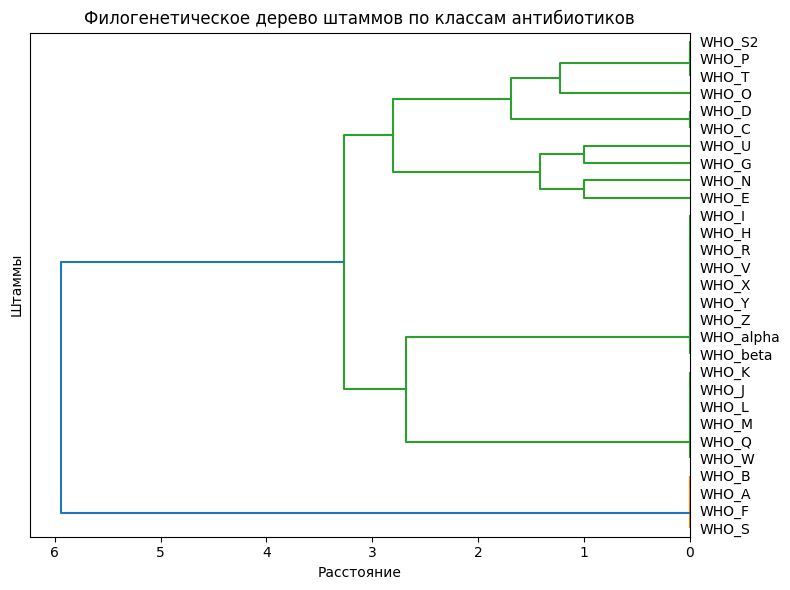

In [15]:
# @title ШАГ 15 Пробуем в деревья

import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from scipy.cluster.hierarchy import linkage, dendrogram

# 📂 1. Пусть к папке с файлами CARD
folder_path = "/content/card"
all_files = glob(os.path.join(folder_path, "*.txt"))

# 📌 2. Функция для извлечения классов антибиотиков из каждого файла
df_list = []
strain_names = []

for file in all_files:
    try:
        df = pd.read_csv(file, sep="\t", engine='python')

        # Получаем имя штамма из названия файла
        filename = os.path.basename(file)
        match = re.search(r'WHO_[A-Za-z0-9]+', filename)
        strain = match.group(0) if match else filename

        # Извлекаем колонку 'Drug Class' или аналогичную (убедись, что колонка называется именно так)
        if "Drug Class" not in df.columns:
            continue

        # Некоторые строки содержат несколько классов через ";"
        for entry in df["Drug Class"].dropna():
            for cls in entry.split(";"):
                df_list.append((strain, cls.strip()))

        strain_names.append(strain)

    except Exception as e:
        print(f"Ошибка в файле {file}: {e}")

# 🧪 3. Создаём DataFrame из собранной информации
df_classes = pd.DataFrame(df_list, columns=["Strain", "Class"])
df_classes["Value"] = 1

# 🧮 4. Создаём матрицу присутствия классов антибиотиков
class_matrix = df_classes.pivot_table(index="Strain", columns="Class", values="Value", aggfunc="max", fill_value=0)

# ➕ 5. Добавим штаммы, которых нет в матрице (с нулями)
all_strains = sorted(set(re.search(r'WHO_[A-Za-z0-9]+', os.path.basename(f)).group(0)
                         for f in all_files if re.search(r'WHO_[A-Za-z0-9]+', os.path.basename(f))))
for strain in all_strains:
    if strain not in class_matrix.index:
        class_matrix.loc[strain] = 0

# Упорядочим
class_matrix = class_matrix.sort_index()

# 🌳 6. Построим дендрограмму
linkage_matrix = linkage(class_matrix.values, method='ward')

plt.figure(figsize=(8, 6))
dendrogram(linkage_matrix, labels=class_matrix.index, orientation='left')
plt.title("Филогенетическое дерево штаммов по классам антибиотиков")
plt.xlabel("Расстояние")
plt.ylabel("Штаммы")
plt.tight_layout()
plt.show()


In [16]:
# @title ШАГ 16 Извлечение SNP

import os
import csv

# Папка с .txt файлами
folder_path = "card"
output_snps = set()  # Используем set, чтобы исключить дубликаты

# Проходим по всем .txt файлам в папке
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, newline='', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            if "SNPs_in_Best_Hit_ARO" not in reader.fieldnames:
                continue  # пропускаем, если колонки нет

            for row in reader:
                snp_field = row.get("SNPs_in_Best_Hit_ARO", "").strip()
                if snp_field:
                    # Предположим, SNP разделены запятыми или точкой с запятой
                    snps = [s.strip() for s in snp_field.replace(';', ',').split(',') if s.strip()]
                    output_snps.update(snps)

# Сохраняем в файл
with open("best_snps_summary.txt", "w", encoding="utf-8") as out_file:
    for snp in sorted(output_snps):
        out_file.write(snp + "\n")

print(f"Извлечено {len(output_snps)} уникальных SNP в best_snps_summary.txt")


Извлечено 28 уникальных SNP в best_snps_summary.txt


In [17]:
# @title ШАГ 17 SNP в генах и со штаммами

import os
import csv
import re
from collections import defaultdict

# Карта: ключевые слова -> красивые имена генов
gene_name_map = {
    "neisseria gonorrhoeae 16s rrna": "16S rRNA",
    "porin pib": "porB",
    "pbp1": "PBP1",
    "pbp2": "PBP2",
    "gyra": "gyrA",
    "mtrc": "mtrC",
    "mtrr": "mtrR",
    "parc": "parC",
    "por": "porB",
    "tem-1": "TEM-1",
    "tem-135": "TEM-135",
    "maca": "macA",
    "macb": "macB",
    "mtra": "mtrA",
    "rpsj": "rpsJ",
    "tet(m)": "tet(M)",
    "pena": "penA",
    "pona": "ponA"
}

# Нормализация имени гена по ключевым словам
def normalize_gene(raw_gene: str) -> str:
    raw_gene_lc = raw_gene.lower()
    for key in gene_name_map:
        if key in raw_gene_lc:
            return gene_name_map[key]
    unknown_genes.add(raw_gene)
    return raw_gene.strip()

folder_path = "card"
records_with_snp = []
genes_without_snp = []
unknown_genes = set()

for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)

        # Извлекаем штамм, например "WHO_F" из имени файла
        match = re.search(r'WHO_[A-Za-z0-9]+', filename)
        strain_name = match.group(0) if match else filename

        with open(file_path, newline='', encoding='utf-8') as f:
            reader = csv.DictReader(f, delimiter='\t')
            if "SNPs_in_Best_Hit_ARO" not in reader.fieldnames or "Best_Hit_ARO" not in reader.fieldnames:
                continue

            for row in reader:
                snp_field = row.get("SNPs_in_Best_Hit_ARO", "").strip()
                raw_gene = row.get("Best_Hit_ARO", "").strip()
                gene = normalize_gene(raw_gene)

                # Если есть SNP
                if snp_field and snp_field.lower() not in {"n/a", "-", ".", "none"}:
                    snps = [s.strip() for s in snp_field.replace(';', ',').split(',') if s.strip()]
                    for snp in snps:
                        records_with_snp.append((strain_name, snp, gene))
                else:
                    # Гены без SNP
                    genes_without_snp.append((strain_name, gene))

# Запись результатов
with open("strain_snp_gene.tsv", "w", encoding="utf-8") as out_file:
    out_file.write("Strain\tSNP\tGene\n")
    for strain, snp, gene in sorted(records_with_snp):
        out_file.write(f"{strain}\t{snp}\t{gene}\n")
    # Добавим блок с n/a
    for strain, gene in sorted(genes_without_snp):
        out_file.write(f"{strain}\tn/a\t{gene}\n")

print(f"\n✅ Всего записей со SNP: {len(records_with_snp)}")
print(f"✅ Генов без SNP: {len(genes_without_snp)}")
print("📄 Результат сохранён в strain_snp_gene.tsv")

if unknown_genes:
    print("\n⚠️ Гены, не найденные в словаре нормализации:")
    for g in sorted(unknown_genes):
        print(f" - {g}")



✅ Всего записей со SNP: 252
✅ Генов без SNP: 44
📄 Результат сохранён в strain_snp_gene.tsv


--- Топ-15 наиболее частых комбинаций (Антибиотик / Ген / Механизм) ---
Для легенды (полные названия):
Antibiotic_Gene_Mechanism_full
erythromycin / resistance-nodulation-cell division (RND) antibiotic efflux pump / antibiotic efflux                                                                 56
azithromycin / resistance-nodulation-cell division (RND) antibiotic efflux pump / antibiotic efflux                                                                 56
tetracycline / tetracycline-resistant ribosomal protection protein / antibiotic target protection                                                                   29
ceftriaxone / Penicillin-binding protein mutations conferring resistance to beta-lactam antibiotics / antibiotic target alteration                                  25
cefixime / Penicillin-binding protein mutations conferring resistance to beta-lactam antibiotics / antibiotic target alteration                                     25
tetracycline / General Bacteria

/tmp/ipython-input-18-2039087154.py:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_combinations_plot.values, y=final_labels_for_plot, palette='viridis')


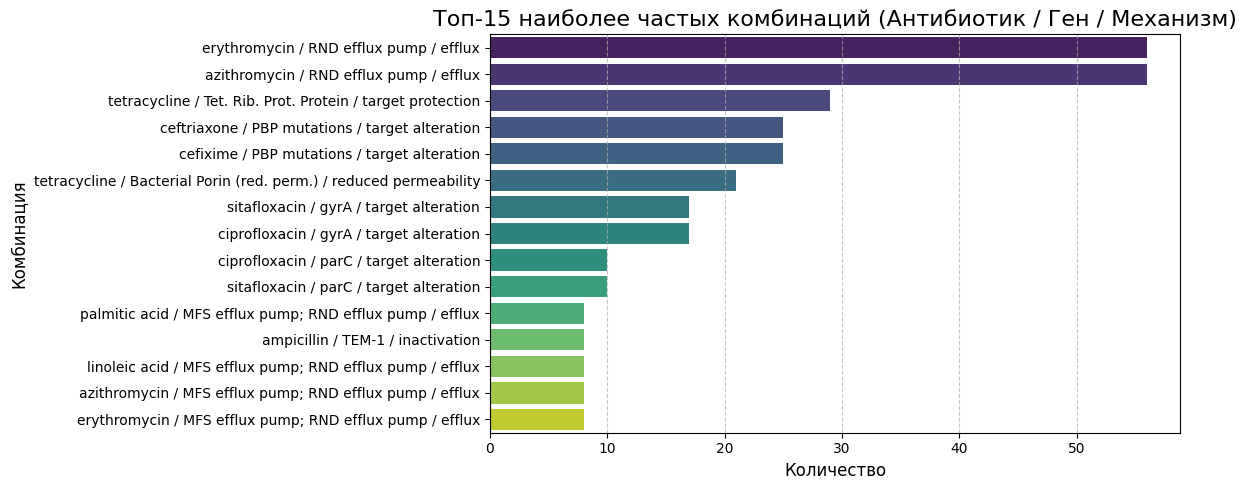

In [18]:
# @title ШАГ 18 Топ 15 комбинаций "Антибиотик / Ген / Механизм устойчивости"

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. Обновленный словарь для сокращения названий генов и механизмов ---
# Ключи будут заменены значениями. Порядок важен: более длинные/специфичные
# фразы должны идти раньше, чтобы они были найдены первыми.
ABBREVIATION_MAP = {
    # Составные/сложные названия, которые встречаются вместе
    "major facilitator superfamily (MFS) antibiotic efflux pump; resistance-nodulation-cell division (RND) antibiotic efflux pump": "MFS/RND efflux pump",
    "General Bacterial Porin with reduced permeability to beta-lactams": "Bacterial Porin (red. perm.)",
    "tetracycline-resistant ribosomal protection protein": "Tet. Rib. Prot. Protein",
    "Penicillin-binding protein mutations conferring resistance to beta-lactam antibiotics": "PBP mutations",


    # Гены (более короткие версии и варианты)
    "penAβ-лактамаза (PBP2)": "penA (PBP2)",
    "Мутации в penA (PBP2) снижают аффинность β-лактамов": "penA (PBP2) mut.",
    "ponAPBP1": "ponA (PBP1)",
    "Мутации снижают чувствительность к пенициллину": "penicillin sensitivity mut.",
    "mtrA / mtrC / mtrR": "mtrABC/R",
    "Компоненты MtrCDE-системы": "MtrCDE system",
    "porB": "porB",
    "Порин PIB": "Porin PIB",
    "gyrA": "gyrA",
    "parC": "parC",
    "fluoroquinolone resistant gyrA": "gyrA",
    "fluoroquinolone resistant parC": "parC",
    "ТОП-изомеразы": "Topoisomerase",
    "rpsJ": "rpsJ",
    "Рибосомный белок": "Ribosomal protein",
    "TEM-1": "TEM-1",
    "TEM beta-lactamase": "TEM-1",
    "tet(M)": "tet(M)",
    "Рибосомопротектор": "Ribosomal protector",
    "macA / macB": "macAB",
    "16S rRNA": "16S rRNA",
    "Рибосомная РНК": "Ribosomal RNA",
    "resistance-nodulation-cell division (RND) antibiotic efflux pump": "RND efflux pump",
    "major facilitator superfamily (MFS) antibiotic efflux pump": "MFS efflux pump",

    # Механизмы
    "antibiotic efflux": "efflux",
    "Эффлюкс антибиотиков": "efflux",
    "Выкачивает макролиды (например, азитромицин)": "macrolide efflux",
    "antibiotic target alteration": "target alteration",
    "antibiotic target protection": "target protection",
    "reduced permeability to antibiotic": "reduced permeability",
    "reduced permeability": "reduced permeability",
    "antibiotic inactivation": "inactivation",
    "Разрушает пенициллины": "penicillin inactivation",
    "Защищает рибосому от действия тетрациклина": "ribosome protection (tetracycline)",
    "Изменения → снижают проницаемость внешней мембраны": "red. outer membrane perm."
}

def apply_abbreviations(text):
    """Применяет серию сокращений к данному тексту.
    Если текст содержит '; ', обрабатывает каждую часть отдельно.
    """
    if '; ' in text:
        parts = [part.strip() for part in text.split(';')]
        processed_parts = []
        for part in parts:
            # Сортируем ключи по убыванию длины, чтобы более специфичные/длинные
            # фразы заменялись первыми.
            sorted_keys = sorted(ABBREVIATION_MAP.keys(), key=len, reverse=True)
            for long_form in sorted_keys:
                if long_form in part:
                    part = part.replace(long_form, ABBREVIATION_MAP[long_form])
            processed_parts.append(part)
        return '; '.join(processed_parts)
    else:
        # Если нет '; ', применяем замены как обычно
        sorted_keys = sorted(ABBREVIATION_MAP.keys(), key=len, reverse=True)
        for long_form in sorted_keys:
            text = text.replace(long_form, ABBREVIATION_MAP[long_form])
        return text

# --- Функция для общего сокращения (на случай, если что-то осталось длинным) ---
def shorten_label_fallback(label, max_length=75):
    """
    Сокращает длинную строку, добавляя многоточие, если она превышает max_length.
    """
    if len(label) > max_length:
        return label[:max_length-3] + '...'
    return label

# --- 2. Загрузка данных из указанного файла .csv ---
file_path = "/content/combined_data.csv"

try:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл не найден по пути: {file_path}")

    raw_df = pd.read_csv(file_path)

except FileNotFoundError as e:
    print(f"❌ Ошибка: {e}. Пожалуйста, загрузите файл `combined_data.csv` или укажите его корректное имя.")
    exit()
except Exception as e:
    print(f"❌ Произошла ошибка при загрузке файла: {e}")
    exit()

# --- 3. Предобработка: Подготовка данных для визуализации ---

required_columns_for_viz = ['Antibiotic', 'AMR Gene Family', 'Resistance Mechanism', 'Source_File']

if not all(col in raw_df.columns for col in required_columns_for_viz):
    print(f"❌ Ошибка: Не все необходимые столбцы найдены в '{file_path}'.")
    exit()

raw_df['Strain'] = raw_df['Source_File'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# Создаем комбинированный столбец с ПОЛНЫМИ названиями для вывода в консоль
df_combined_exploded_full = raw_df.assign(
    Antibiotic=raw_df['Antibiotic'].astype(str).str.split('; ')
).explode('Antibiotic')
df_combined_exploded_full['Antibiotic'] = df_combined_exploded_full['Antibiotic'].str.strip()
df_combined_exploded_full = df_combined_exploded_full.dropna(subset=['Antibiotic', 'AMR Gene Family', 'Resistance Mechanism'])
df_combined_exploded_full = df_combined_exploded_full[df_combined_exploded_full['Antibiotic'] != 'nan']
df_combined_exploded_full = df_combined_exploded_full[df_combined_exploded_full['Antibiotic'] != 'n/a']
df_combined_exploded_full = df_combined_exploded_full[df_combined_exploded_full['AMR Gene Family'] != 'n/a']
df_combined_exploded_full = df_combined_exploded_full[df_combined_exploded_full['Resistance Mechanism'] != 'n/a']
if df_combined_exploded_full.empty:
    print("❌ ВНИМАНИЕ: DataFrame пуст после очистки! Проверьте исходные данные.")
    exit()
df_combined_exploded_full = df_combined_exploded_full.reset_index(drop=True)

df_combined_exploded_full['Antibiotic_Gene_Mechanism_full'] = \
    df_combined_exploded_full['Antibiotic'].astype(str) + " / " + \
    df_combined_exploded_full['AMR Gene Family'].astype(str) + " / " + \
    df_combined_exploded_full['Resistance Mechanism'].astype(str)


# Создаем DataFrame для графика, применяя сокращения
df_combined_exploded_processed = raw_df.assign(
    Antibiotic=raw_df['Antibiotic'].astype(str).str.split('; ')
).explode('Antibiotic')
df_combined_exploded_processed['Antibiotic'] = df_combined_exploded_processed['Antibiotic'].str.strip()
df_combined_exploded_processed = df_combined_exploded_processed.dropna(subset=['Antibiotic', 'AMR Gene Family', 'Resistance Mechanism'])
df_combined_exploded_processed = df_combined_exploded_processed[df_combined_exploded_processed['Antibiotic'] != 'nan']
df_combined_exploded_processed = df_combined_exploded_processed[df_combined_exploded_processed['Antibiotic'] != 'n/a']
df_combined_exploded_processed = df_combined_exploded_processed[df_combined_exploded_processed['AMR Gene Family'] != 'n/a']
df_combined_exploded_processed = df_combined_exploded_processed[df_combined_exploded_processed['Resistance Mechanism'] != 'n/a']
if df_combined_exploded_processed.empty:
    print("❌ ВНИМАНИЕ: DataFrame пуст после очистки! Проверьте исходные данные.")
    exit()
df_combined_exploded_processed = df_combined_exploded_processed.reset_index(drop=True)


df_combined_exploded_processed['AMR Gene Family_processed'] = df_combined_exploded_processed['AMR Gene Family'].apply(apply_abbreviations)
df_combined_exploded_processed['Resistance Mechanism_processed'] = df_combined_exploded_processed['Resistance Mechanism'].apply(apply_abbreviations)

df_combined_exploded_processed['Antibiotic_Gene_Mechanism_combined_for_plot'] = \
    df_combined_exploded_processed['Antibiotic'].astype(str) + " / " + \
    df_combined_exploded_processed['AMR Gene Family_processed'].astype(str) + " / " + \
    df_combined_exploded_processed['Resistance Mechanism_processed'].astype(str)


# --- Визуализация: Обзор наиболее частых комбинаций (Антибиотик / Ген / Механизм) ---

# Подсчитываем частоту для полной версии (для вывода в консоль)
top_combinations_full = df_combined_exploded_full['Antibiotic_Gene_Mechanism_full'].value_counts().head(15)

# Подсчитываем частоту для сокращенной версии (для графика)
top_combinations_plot = df_combined_exploded_processed['Antibiotic_Gene_Mechanism_combined_for_plot'].value_counts().head(15)


# --- Вывод финального результата и графика ---
print("--- Топ-15 наиболее частых комбинаций (Антибиотик / Ген / Механизм) ---")
print("Для легенды (полные названия):")
print(top_combinations_full.to_string()) # Используем .to_string() для полного отображения

if top_combinations_plot.empty:
    print("❌ Нет данных для построения графика 'Топ-15 комбинаций'.")
else:
    # Применяем общую функцию сокращения на случай, если после аббревиатур комбинация все еще длинная
    final_labels_for_plot = top_combinations_plot.index.map(lambda x: shorten_label_fallback(x, max_length=75))

    plt.figure(figsize=(12, 5))
    sns.barplot(x=top_combinations_plot.values, y=final_labels_for_plot, palette='viridis')
    plt.title('Топ-15 наиболее частых комбинаций (Антибиотик / Ген / Механизм)', fontsize=16)
    plt.xlabel('Количество', fontsize=12)
    plt.ylabel('Комбинация', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

--- Топ-25 наиболее частых комбинаций (Антибиотик / Ген / Механизм) ---
Для легенды (полные названия):
Antibiotic_Gene_Mechanism_full
erythromycin / resistance-nodulation-cell division (RND) antibiotic efflux pump / antibiotic efflux                                                                 56
azithromycin / resistance-nodulation-cell division (RND) antibiotic efflux pump / antibiotic efflux                                                                 56
tetracycline / tetracycline-resistant ribosomal protection protein / antibiotic target protection                                                                   29
ceftriaxone / Penicillin-binding protein mutations conferring resistance to beta-lactam antibiotics / antibiotic target alteration                                  25
cefixime / Penicillin-binding protein mutations conferring resistance to beta-lactam antibiotics / antibiotic target alteration                                     25
tetracycline / General Bacteria

/tmp/ipython-input-19-3701243575.py:185: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_combinations_plot.values, y=final_labels_for_plot, palette='viridis')


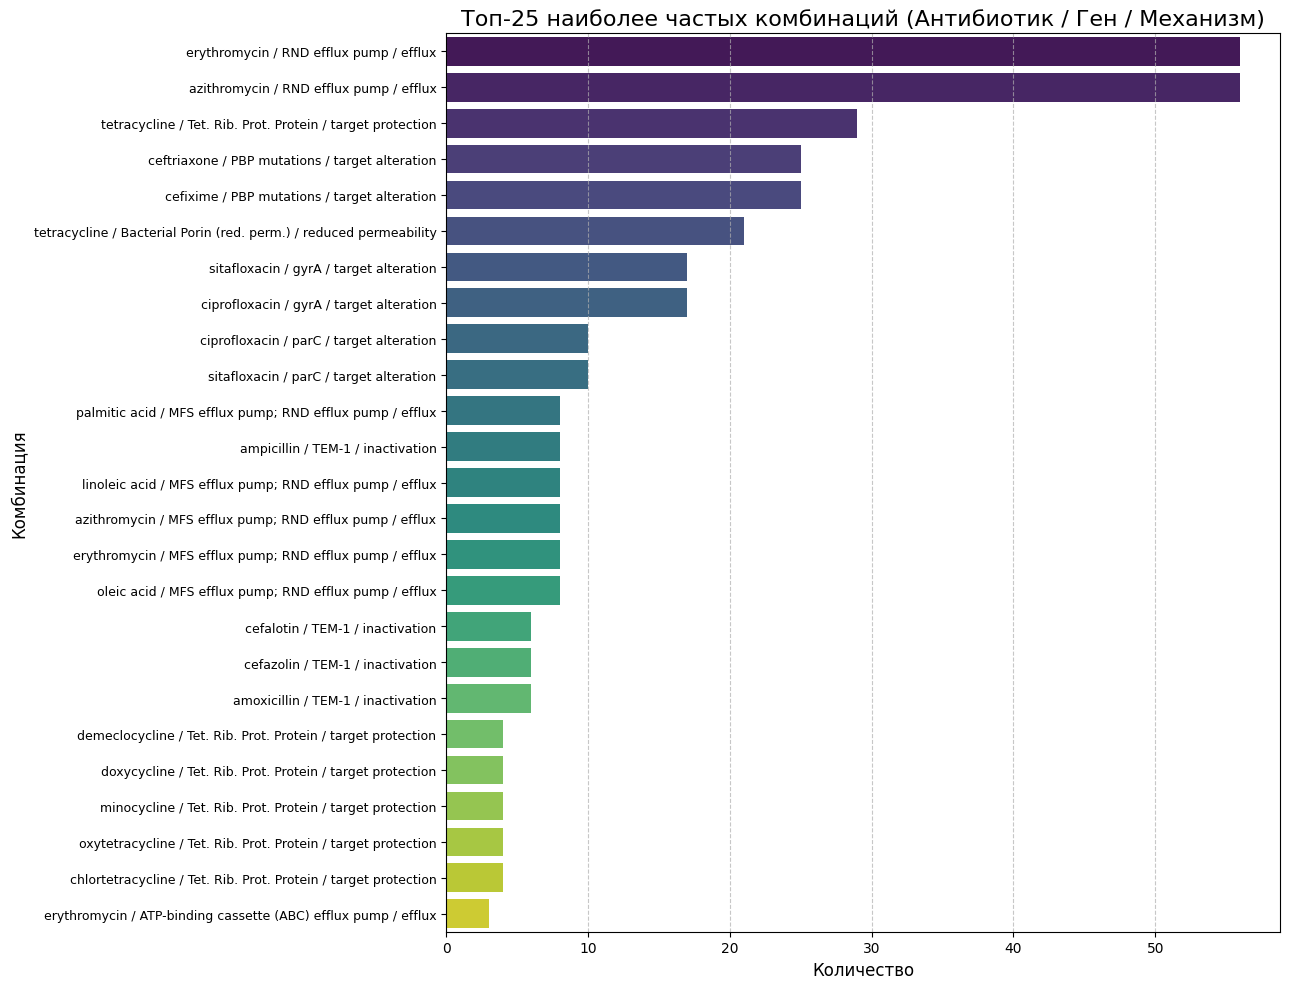

In [19]:
# @title ШАГ 19 Топ-25 комбинаций

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. Обновленный словарь для сокращения названий генов и механизмов ---
# Ключи будут заменены значениями. Порядок важен: более длинные/специфичные
# фразы должны идти раньше, чтобы они были найдены первыми.
ABBREVIATION_MAP = {
    # Составные/сложные названия, которые встречаются вместе
    "major facilitator superfamily (MFS) antibiotic efflux pump; resistance-nodulation-cell division (RND) antibiotic efflux pump": "MFS/RND efflux pump",
    "General Bacterial Porin with reduced permeability to beta-lactams": "Bacterial Porin (red. perm.)",
    "tetracycline-resistant ribosomal protection protein": "Tet. Rib. Prot. Protein",
    "Penicillin-binding protein mutations conferring resistance to beta-lactam antibiotics": "PBP mutations",


    # Гены (более короткие версии и варианты)
    "penAβ-лактамаза (PBP2)": "penA (PBP2)",
    "Мутации в penA (PBP2) снижают аффинность β-лактамов": "penA (PBP2) mut.",
    "ponAPBP1": "ponA (PBP1)",
    "Мутации снижают чувствительность к пенициллину": "penicillin sensitivity mut.",
    "mtrA / mtrC / mtrR": "mtrABC/R",
    "Компоненты MtrCDE-системы": "MtrCDE system",
    "porB": "porB",
    "Порин PIB": "Porin PIB",
    "gyrA": "gyrA",
    "parC": "parC",
    "fluoroquinolone resistant gyrA": "gyrA",
    "fluoroquinolone resistant parC": "parC",
    "ТОП-изомеразы": "Topoisomerase",
    "rpsJ": "rpsJ",
    "Рибосомный белок": "Ribosomal protein",
    "TEM-1": "TEM-1",
    "TEM beta-lactamase": "TEM-1",
    "tet(M)": "tet(M)",
    "Рибосомопротектор": "Ribosomal protector",
    "macA / macB": "macAB",
    "16S rRNA": "16S rRNA",
    "Рибосомная РНК": "Ribosomal RNA",
    "resistance-nodulation-cell division (RND) antibiotic efflux pump": "RND efflux pump",
    "major facilitator superfamily (MFS) antibiotic efflux pump": "MFS efflux pump",

    # Механизмы
    "antibiotic efflux": "efflux",
    "Эффлюкс антибиотиков": "efflux",
    "Выкачивает макролиды (например, азитромицин)": "macrolide efflux",
    "antibiotic target alteration": "target alteration",
    "antibiotic target protection": "target protection",
    "reduced permeability to antibiotic": "reduced permeability",
    "reduced permeability": "reduced permeability",
    "antibiotic inactivation": "inactivation",
    "Разрушает пенициллины": "penicillin inactivation",
    "Защищает рибосому от действия тетрациклина": "ribosome protection (tetracycline)",
    "Изменения → снижают проницаемость внешней мембраны": "red. outer membrane perm."
}

def apply_abbreviations(text):
    """Применяет серию сокращений к данному тексту.
    Если текст содержит '; ', обрабатывает каждую часть отдельно.
    """
    if '; ' in text:
        parts = [part.strip() for part in text.split(';')]
        processed_parts = []
        for part in parts:
            # Сортируем ключи по убыванию длины, чтобы более специфичные/длинные
            # фразы заменялись первыми.
            sorted_keys = sorted(ABBREVIATION_MAP.keys(), key=len, reverse=True)
            for long_form in sorted_keys:
                if long_form in part:
                    part = part.replace(long_form, ABBREVIATION_MAP[long_form])
            processed_parts.append(part)
        return '; '.join(processed_parts)
    else:
        # Если нет '; ', применяем замены как обычно
        sorted_keys = sorted(ABBREVIATION_MAP.keys(), key=len, reverse=True)
        for long_form in sorted_keys:
            text = text.replace(long_form, ABBREVIATION_MAP[long_form])
        return text

# --- Функция для общего сокращения (на случай, если что-то осталось длинным) ---
def shorten_label_fallback(label, max_length=75):
    """
    Сокращает длинную строку, добавляя многоточие, если она превышает max_length.
    """
    if len(label) > max_length:
        return label[:max_length-3] + '...'
    return label

# --- 2. Загрузка данных из указанного файла .csv ---
file_path = "/content/combined_data.csv"

try:
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл не найден по пути: {file_path}")

    raw_df = pd.read_csv(file_path)

except FileNotFoundError as e:
    print(f"❌ Ошибка: {e}. Пожалуйста, загрузите файл `combined_data.csv` или укажите его корректное имя.")
    exit()
except Exception as e:
    print(f"❌ Произошла ошибка при загрузке файла: {e}")
    exit()

# --- 3. Предобработка: Подготовка данных для визуализации ---

required_columns_for_viz = ['Antibiotic', 'AMR Gene Family', 'Resistance Mechanism', 'Source_File']

if not all(col in raw_df.columns for col in required_columns_for_viz):
    print(f"❌ Ошибка: Не все необходимые столбцы найдены в '{file_path}'.")
    exit()

raw_df['Strain'] = raw_df['Source_File'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# Создаем комбинированный столбец с ПОЛНЫМИ названиями для вывода в консоль
df_combined_exploded_full = raw_df.assign(
    Antibiotic=raw_df['Antibiotic'].astype(str).str.split('; ')
).explode('Antibiotic')
df_combined_exploded_full['Antibiotic'] = df_combined_exploded_full['Antibiotic'].str.strip()
df_combined_exploded_full = df_combined_exploded_full.dropna(subset=['Antibiotic', 'AMR Gene Family', 'Resistance Mechanism'])
df_combined_exploded_full = df_combined_exploded_full[df_combined_exploded_full['Antibiotic'] != 'nan']
df_combined_exploded_full = df_combined_exploded_full[df_combined_exploded_full['Antibiotic'] != 'n/a']
df_combined_exploded_full = df_combined_exploded_full[df_combined_exploded_full['AMR Gene Family'] != 'n/a']
df_combined_exploded_full = df_combined_exploded_full[df_combined_exploded_full['Resistance Mechanism'] != 'n/a']
if df_combined_exploded_full.empty:
    print("❌ ВНИМАНИЕ: DataFrame пуст после очистки! Проверьте исходные данные.")
    exit()
df_combined_exploded_full = df_combined_exploded_full.reset_index(drop=True)

df_combined_exploded_full['Antibiotic_Gene_Mechanism_full'] = \
    df_combined_exploded_full['Antibiotic'].astype(str) + " / " + \
    df_combined_exploded_full['AMR Gene Family'].astype(str) + " / " + \
    df_combined_exploded_full['Resistance Mechanism'].astype(str)


# Создаем DataFrame для графика, применяя сокращения
df_combined_exploded_processed = raw_df.assign(
    Antibiotic=raw_df['Antibiotic'].astype(str).str.split('; ')
).explode('Antibiotic')
df_combined_exploded_processed['Antibiotic'] = df_combined_exploded_processed['Antibiotic'].str.strip()
df_combined_exploded_processed = df_combined_exploded_processed.dropna(subset=['Antibiotic', 'AMR Gene Family', 'Resistance Mechanism'])
df_combined_exploded_processed = df_combined_exploded_processed[df_combined_exploded_processed['Antibiotic'] != 'nan']
df_combined_exploded_processed = df_combined_exploded_processed[df_combined_exploded_processed['Antibiotic'] != 'n/a']
df_combined_exploded_processed = df_combined_exploded_processed[df_combined_exploded_processed['AMR Gene Family'] != 'n/a']
df_combined_exploded_processed = df_combined_exploded_processed[df_combined_exploded_processed['Resistance Mechanism'] != 'n/a']
if df_combined_exploded_processed.empty:
    print("❌ ВНИМАНИЕ: DataFrame пуст после очистки! Проверьте исходные данные.")
    exit()
df_combined_exploded_processed = df_combined_exploded_processed.reset_index(drop=True)


df_combined_exploded_processed['AMR Gene Family_processed'] = df_combined_exploded_processed['AMR Gene Family'].apply(apply_abbreviations)
df_combined_exploded_processed['Resistance Mechanism_processed'] = df_combined_exploded_processed['Resistance Mechanism'].apply(apply_abbreviations)

df_combined_exploded_processed['Antibiotic_Gene_Mechanism_combined_for_plot'] = \
    df_combined_exploded_processed['Antibiotic'].astype(str) + " / " + \
    df_combined_exploded_processed['AMR Gene Family_processed'].astype(str) + " / " + \
    df_combined_exploded_processed['Resistance Mechanism_processed'].astype(str)


# --- Визуализация: Обзор наиболее частых комбинаций (Антибиотик / Ген / Механизм) ---

# Подсчитываем частоту для полной версии (для вывода в консоль) - ТОП 25
top_combinations_full = df_combined_exploded_full['Antibiotic_Gene_Mechanism_full'].value_counts().head(25)

# Подсчитываем частоту для сокращенной версии (для графика) - ТОП 25
top_combinations_plot = df_combined_exploded_processed['Antibiotic_Gene_Mechanism_combined_for_plot'].value_counts().head(25)


# --- Вывод финального результата и графика ---
print("--- Топ-25 наиболее частых комбинаций (Антибиотик / Ген / Механизм) ---")
print("Для легенды (полные названия):")
print(top_combinations_full.to_string()) # Используем .to_string() для полного отображения

if top_combinations_plot.empty:
    print("❌ Нет данных для построения графика 'Топ-25 комбинаций'.")
else:
    # Применяем общую функцию сокращения на случай, если после аббревиатур комбинация все еще длинная
    final_labels_for_plot = top_combinations_plot.index.map(lambda x: shorten_label_fallback(x, max_length=75))

    # Увеличиваем высоту графика, чтобы вместить 25 баров
    plt.figure(figsize=(13, 10)) # Увеличенная высота для 25 элементов
    sns.barplot(x=top_combinations_plot.values, y=final_labels_for_plot, palette='viridis')
    plt.title('Топ-25 наиболее частых комбинаций (Антибиотик / Ген / Механизм)', fontsize=16)
    plt.xlabel('Количество', fontsize=12)
    plt.ylabel('Комбинация', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9) # Возможно, придется немного уменьшить шрифт меток Y для 25 элементов
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()